In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string

import torch
import torch.optim as optim
import torch.nn as nn

import utils

from nltk.probability import FreqDist      # module for counting word frequency
from nltk.util import ngrams


In [10]:
#Instantiating data to a separate variables

idf_text = pd.read_pickle('idf_text')
idf_text_list = idf_text.tolist()
hammas_text = pd.read_pickle('hammas_text')
hammas_text_list = hammas_text.tolist()

#idf_tokens = idf_tokens.apply(lambda x: ', '.join(x))
#hammas_tokens = hammas_tokens.apply(lambda x: ', '.join(x))
all_text = hammas_text + idf_text

# split the data into two pieces, one for training and one for testing (validation set)
#I have around 8000 messages in total
test_ham = hammas_text_list[6000:]
train_ham = hammas_text_list[:6000]

test_idf = idf_text_list[6000:]
train_idf = idf_text_list[:6000]


train_x = train_ham + train_idf
test_x = test_ham + test_idf

In [11]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_ham), 1)), np.zeros((len(train_idf), 1)), axis=0)
test_y = np.append(np.ones((len(test_ham), 1)), np.zeros((len(test_idf), 1)), axis=0)

# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

# create frequency dictionary
freqs = utils.build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))


# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= utils.extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = utils.gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 15000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")


train_y.shape = (12000, 1)
test_y.shape = (4452, 1)
type(freqs) = <class 'dict'>
len(freqs) = 22093


/Users/timurburhanov/Projects/GitHub/chat_analysis/utils.py:140: RuntimeWarning: divide by zero encountered in log
  J = - (1/m) * (np.dot(y.T, np.log(h)) + np.dot((1 - y.T), np.log(1 - h)))


The cost after training is nan.
The resulting vector of weights is [2.1e-07, 0.00065654, -0.00046772]


In [38]:
theta = [0.1572,  0.2531, -0.1533]

In [69]:
for text in ['''Popular Front for the Liberation of Palestine:
—
Tulkarem continues to display the most splendid epics of heroism and sacrifice. 

The Popular Front mourns the martyrs of Tulkarem (https://t.me/PalestineResist/47112) and affirms that the resistance will remain a thorn in the throat of the criminal zionist enemy. 

The Popular Front for the Liberation of Palestine mourns a new group of heroic resistance fighters who were martyred yesterday evening, Tuesday, in a cowardly zionist bombing carried out by a drone, (https://t.me/PalestineResist/47090) targeting them in the middle of the brave Nour Shams camp east of the occupied city of Tulkarem.

This new zionist crime adds to the record of brutal crimes committed by the zionist entity against our steadfast people.''']:
  print( '%s -> %f' % (text, utils.predict_text(text, freqs, theta)))

Popular Front for the Liberation of Palestine:
—
Tulkarem continues to display the most splendid epics of heroism and sacrifice. 

The Popular Front mourns the martyrs of Tulkarem (https://t.me/PalestineResist/47112) and affirms that the resistance will remain a thorn in the throat of the criminal zionist enemy. 

The Popular Front for the Liberation of Palestine mourns a new group of heroic resistance fighters who were martyred yesterday evening, Tuesday, in a cowardly zionist bombing carried out by a drone, (https://t.me/PalestineResist/47090) targeting them in the middle of the brave Nour Shams camp east of the occupied city of Tulkarem.

This new zionist crime adds to the record of brutal crimes committed by the zionist entity against our steadfast people. -> 1.000000


/var/folders/hl/d5jnxqdx1tlglj_yhvqpcnsh0000gn/T/ipykernel_68505/1311148967.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (text, utils.predict_text(text, freqs, theta)))


In [8]:
# Some error analysis done for you
print('Label Predicted TEXT')
for x,y in zip(test_x,test_y):
    y_hat = utils.predict_text(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TEXT IS:', x)
        print('THE PROCESSED TEXT IS:', utils.process_text(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(utils.process_text(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: 🚨 BREAKING: After over an hour of fragile silence, missile sirens ring in the settlement of “Nir Am.” Preliminary reports indicate that missiles were launched from Gaza.
THE PROCESSED TWEET IS: ['🚨', 'break', 'after', 'hour', 'fragil', 'silenc', 'missil', 'siren', 'ring', 'settlement', '“', 'nir', 'am.', '”', 'preliminari', 'report', 'indic', 'missil', 'launch', 'gaza']
1	0.09849736	b' break after hour fragil silenc missil siren ring settlement  nir am.  preliminari report indic missil launch gaza'
THE TWEET IS: Five injuries have been reported by the ministry of health in Gaza following the IOF bombing of the Strip yesterday.
THE PROCESSED TWEET IS: ['five', 'injuri', 'report', 'ministri', 'health', 'gaza', 'follow', 'iof', 'bomb', 'strip', 'yesterday']
1	0.03946015	b'five injuri report ministri health gaza follow iof bomb strip yesterday'


/var/folders/hl/d5jnxqdx1tlglj_yhvqpcnsh0000gn/T/ipykernel_68505/3859812774.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(utils.process_text(x)).encode('ascii', 'ignore')))


THE TWEET IS: 🚨 A new round of raids by US-funded IOF warplanes bombs targets in the western Gaza Strip and Gaza City.
THE PROCESSED TWEET IS: ['🚨', 'a', 'new', 'round', 'raid', 'us-fund', 'iof', 'warplan', 'bomb', 'target', 'western', 'gaza', 'strip', 'gaza', 'citi']
1	0.38769651	b' a new round raid us-fund iof warplan bomb target western gaza strip gaza citi'
THE TWEET IS: 🚨 Explosions are reported in Khan Yunis, Gaza Strip, after the zionist forces launched strikes on the city. Details are emerging.
THE PROCESSED TWEET IS: ['🚨', 'explos', 'report', 'khan', 'yuni', 'gaza', 'strip', 'zionist', 'forc', 'launch', 'strike', 'citi', 'detail', 'emerg']
1	0.09021382	b' explos report khan yuni gaza strip zionist forc launch strike citi detail emerg'
THE TWEET IS: 🚨 US-funded IOF warplanes are now bombing various areas in the Gaza Strip.
THE PROCESSED TWEET IS: ['🚨', 'us-fund', 'iof', 'warplan', 'bomb', 'variou', 'area', 'gaza', 'strip']
1	0.21518725	b' us-fund iof warplan bomb variou area ga

THE TWEET IS: bold🚨 IOF warplanes targeted agricultural fields in Rafah in the south of Gaza as well as in the north of the Strip.
THE PROCESSED TWEET IS: ['bold🚨', 'iof', 'warplan', 'target', 'agricultur', 'field', 'rafah', 'south', 'gaza', 'well', 'north', 'strip']
1	0.48183282	b'bold iof warplan target agricultur field rafah south gaza well north strip'
THE TWEET IS: The Ministry of Health in Gaza: 33 citizens, including six children and three women, have ascended to martyrdom as a result of the ongoing “israeli” aggression on Gaza and 147 civilians were wounded.
THE PROCESSED TWEET IS: ['the', 'ministri', 'health', 'gaza', '33', 'citizen', 'includ', 'six', 'children', 'three', 'women', 'ascend', 'martyrdom', 'result', 'ongo', '“', 'isra', '”', 'aggress', 'gaza', '147', 'civilian', 'wound']
1	0.40590491	b'the ministri health gaza 33 citizen includ six children three women ascend martyrdom result ongo  isra  aggress gaza 147 civilian wound'
THE TWEET IS: bold🚨 IOF warplanes have dire

THE TWEET IS: IDF: The Commanding Officer of the 91st Division and the the Commanding Officer of the 146th Division met with heads of authorities and councils in the north before Passover: "Our commitment is to be here until the reality changes"The Commanding Officer of the 91st Galilee Division, BG Shay Kalper and the Commanding Officer of the 146th Division, BG Yisrael Shomer met yesterday (Wednesday) with the heads of the local authorities, councils, and the security officers in the north of Israel.As part of the meeting, a conversation was held with the heads of the authorities, in which they were presented with the situational assessment so far, as well as the processes to accelerate the readiness for continued fighting in the north of Israel.The commanding officers of the divisions expressed their appreciation to the heads of the local authorities, councils, and the security officers for demonstrating true leadership and dedication over the past six months. He thanked them for pl

# Doing the same but using PyTorch below


In [33]:
# combine positive and negative labels
train_y_torch = torch.cat((torch.ones((len(train_ham), 1)), torch.zeros((len(train_idf), 1))))
test_y_torch = torch.cat((torch.ones((len(test_ham), 1)), torch.zeros((len(test_idf), 1))))


# collect the features 'x' and stack them into a matrix 'X'
x_train = torch.zeros((len(train_x), 3))
for i in range(len(train_x)):
    x_train[i, :]= utils.extract_features_t(train_x[i], freqs)
    
x_test = torch.zeros((len(test_x), 3))
for i in range(len(test_x)):
    x_test[i, :]= utils.extract_features_t(test_x[i], freqs)

In [34]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_train, t_val,
                  t_cl_train, t_cl_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_train)
        loss_train = loss_fn(t_p_train, t_cl_train)

        t_p_val = model(t_val)
        loss_val = loss_fn(t_p_val, t_cl_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f"Validation loss {loss_val.item():.4f}")

linear_model = nn.Sequential(
            nn.Linear(3, 1),
            nn.Sigmoid()
            )
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-3)

loss_fn = nn.BCELoss()


In [35]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_train = x_train,
    t_val = x_test,
    t_cl_train = train_y_torch,
    t_cl_val = test_y_torch)

Epoch 1, Training loss 37.2899,Validation loss 40.1194
Epoch 1000, Training loss 0.4514,Validation loss 0.8641
Epoch 2000, Training loss 0.4649,Validation loss 0.8937
Epoch 3000, Training loss 0.4659,Validation loss 0.8701
Epoch 4000, Training loss 0.4558,Validation loss 0.8774
Epoch 5000, Training loss 0.4561,Validation loss 0.8708


In [40]:
torch.save(linear_model.state_dict(), 'logistic_regression.pt')

In [36]:
theta_p = next(linear_model.parameters())
theta_p = theta_p.squeeze().detach().numpy()
theta_p 

array([-0.52312   ,  0.48137847, -0.33270127], dtype=float32)

In [18]:
model = linear_model
model.load_state_dict(torch.load('logistic_regression.pt'))

<All keys matched successfully>

In [37]:
for text in ['''The number of martyrs (https://t.me/PalestineResist/48831) as a result of the IOF strike targeting displaced people in Al-Attar Street near Khan Younis, southern #Gaza Strip, has been raised to at least 17 martyrs and more than 26 injuries were reported (media 2 in Al-Nasser hospital). 

In addition, at least 20 martyrs have ascended and dozens of injuries were reported after the IOF targeted an UNRWA school (https://t.me/PalestineResist/48831) housing displaced people in Nusseirat camp, in central #Gaza Strip.''']:
  print( '%s -> %f' % (text, utils.predict_text(text, freqs, theta_p)))

The number of martyrs (https://t.me/PalestineResist/48831) as a result of the IOF strike targeting displaced people in Al-Attar Street near Khan Younis, southern #Gaza Strip, has been raised to at least 17 martyrs and more than 26 injuries were reported (media 2 in Al-Nasser hospital). 

In addition, at least 20 martyrs have ascended and dozens of injuries were reported after the IOF targeted an UNRWA school (https://t.me/PalestineResist/48831) housing displaced people in Nusseirat camp, in central #Gaza Strip. -> 1.000000


/var/folders/hl/d5jnxqdx1tlglj_yhvqpcnsh0000gn/T/ipykernel_73790/2659313386.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (text, utils.predict_text(text, freqs, theta_p)))


In [38]:
# Some error analysis done for you
print('Label Predicted TEXT')
for x,y in zip(test_x,test_y):
    y_hat = utils.predict_text(x, freqs, theta_p)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TEXT IS:', x)
        print('THE PROCESSED TEXT IS:', utils.process_text(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(utils.process_text(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TEXT IS: 🚨 BREAKING: After over an hour of fragile silence, missile sirens ring in the settlement of “Nir Am.” Preliminary reports indicate that missiles were launched from Gaza.
THE PROCESSED TEXT IS: ['🚨', 'break', 'after', 'hour', 'fragil', 'silenc', 'missil', 'siren', 'ring', 'settlement', '“', 'nir', 'am.', '”', 'preliminari', 'report', 'indic', 'missil', 'launch', 'gaza']
1	0.00000000	b' break after hour fragil silenc missil siren ring settlement  nir am.  preliminari report indic missil launch gaza'
THE TEXT IS: Five injuries have been reported by the ministry of health in Gaza following the IOF bombing of the Strip yesterday.
THE PROCESSED TEXT IS: ['five', 'injuri', 'report', 'ministri', 'health', 'gaza', 'follow', 'iof', 'bomb', 'strip', 'yesterday']
1	0.00000000	b'five injuri report ministri health gaza follow iof bomb strip yesterday'
THE TEXT IS: 🚨 A new round of raids by US-funded IOF warplanes bombs targets in the western Gaza Strip and Gaza Cit

/var/folders/hl/d5jnxqdx1tlglj_yhvqpcnsh0000gn/T/ipykernel_73790/795965422.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(utils.process_text(x)).encode('ascii', 'ignore')))


THE TEXT IS: 🚨 Explosions are reported in Khan Yunis, Gaza Strip, after the zionist forces launched strikes on the city. Details are emerging.
THE PROCESSED TEXT IS: ['🚨', 'explos', 'report', 'khan', 'yuni', 'gaza', 'strip', 'zionist', 'forc', 'launch', 'strike', 'citi', 'detail', 'emerg']
1	0.00000000	b' explos report khan yuni gaza strip zionist forc launch strike citi detail emerg'
THE TEXT IS: 🚨 US-funded IOF warplanes are now bombing various areas in the Gaza Strip.
THE PROCESSED TEXT IS: ['🚨', 'us-fund', 'iof', 'warplan', 'bomb', 'variou', 'area', 'gaza', 'strip']
1	0.00000000	b' us-fund iof warplan bomb variou area gaza strip'
THE TEXT IS: 🚨 IOF aggression continues in various areas on the Gaza Strip.
THE PROCESSED TEXT IS: ['🚨', 'iof', 'aggress', 'continu', 'variou', 'area', 'gaza', 'strip']
1	0.00000000	b' iof aggress continu variou area gaza strip'
THE TEXT IS: Over 300 rockets were launched from Gaza in the last three hours.
THE PROCESSED TEXT IS: ['over', '300', 'rocket', '

THE TEXT IS: 🚨🚀 Missile sirens ring in all settlements surrounding Gaza as the resistance launches barrages of rockets towards them.
THE PROCESSED TEXT IS: ['🚨🚀', 'missil', 'siren', 'ring', 'settlement', 'surround', 'gaza', 'resist', 'launch', 'barrag', 'rocket', 'toward']
1	0.00000000	b' missil siren ring settlement surround gaza resist launch barrag rocket toward'
THE TEXT IS: 🚨 A number of casualties are reported after IOF warplanes struck a group of rocket launchers in southern Gaza.
THE PROCESSED TEXT IS: ['🚨', 'a', 'number', 'casualti', 'report', 'iof', 'warplan', 'struck', 'group', 'rocket', 'launcher', 'southern', 'gaza']
1	0.00000000	b' a number casualti report iof warplan struck group rocket launcher southern gaza'
THE TEXT IS: customemoji⏺stickers/AnimatedSticker.tgs🎥 RNN is now on TikTok! Support and follow us here:link
THE PROCESSED TEXT IS: ['customemoji⏺stickers/animatedsticker.tgs🎥', 'rnn', 'tiktok', 'support', 'follow', 'us', 'link']
1	0.00000000	b'customemojistickers/

THE TEXT IS: Attached are the full remarks of the Chief of the General Staff: "So far, the results are good, but see, we are targeting the leaders. Marwan Issa, the arrest of senior operatives. This is very, very important for pressuring Hamas, it's very important for pressuring the negotiations as well, and we are serving two purposes here. A heavy strike on Hamas, dismantling Hamas, killing Hamas’ military leadership, striking the civil leadership, striking the operatives. And not to allow such a place to be controlled, and we are also putting pressure on the negotiations. We came here to apprehend many operatives, with an emphasis on senior operatives, and to kill those who fight. We prefer prisoners, they are important cards, for interrogations, you understand this, to kill whoever fights. So far, the performance of the mission is very good. The method of operation, I tell you, from the start we've been talking about the element of surprise operations, deception, and here maybe the

In [39]:
tmp_accuracy = utils.test_logistic_regression(test_x, test_y, freqs, theta_p)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")


Logistic regression model's accuracy = 0.9908


In [11]:
#selected 11 most common words from each at random

keys = ['arrest','entiti','tulkarem','settlement','resist','martyr','zionist','allah', '🚨', 'soldier',
         'hospit','fighter','tunnel','organ','lebanon','terrorist','hezbollah','infrastructur','rocket','israel','conduct']


# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:

    # initialize positive and negative counts
    ham = 0
    idf = 0

    # retrieve number of positive counts
    if (word, 1) in freqs:
        ham = freqs[(word, 1)]

    # retrieve number of negative counts
    if (word, 0) in freqs:
        idf = freqs[(word, 0)]

    # append the word counts to the table
    data.append([word, ham, idf])


/Users/timurburhanov/miniconda3/envs/first_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


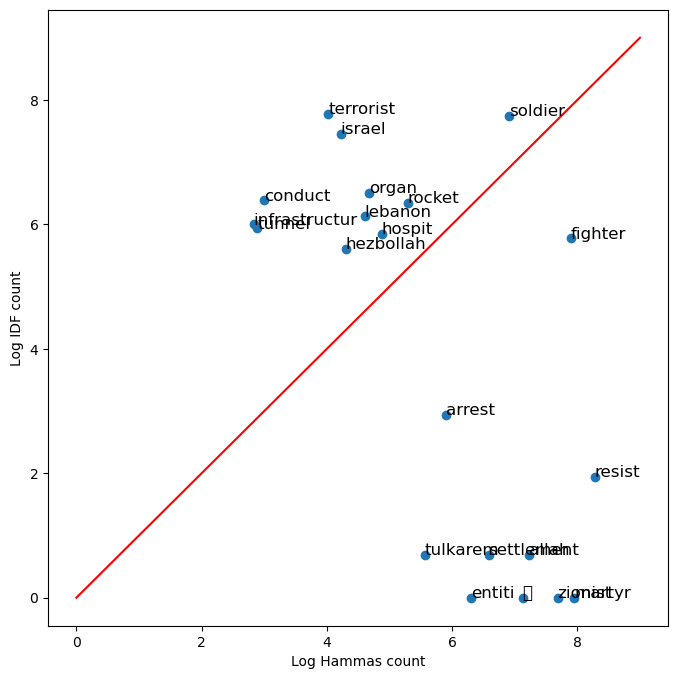

In [12]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data])

# Plot a dot for each pair of words
ax.scatter(x, y)

# assign axis labels
plt.xlabel("Log Hammas count")
plt.ylabel("Log IDF count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

This is experimental code maybe for later

In [14]:
bigrams = ngrams(idf_tokens, 2)

pd.Series(bigrams).value_counts()

NameError: name 'idf_tokens' is not defined

In [ ]:
words_idf = []

for wordList in idf_tokens:
    words_idf += wordList

words_hammas = []

for wordList in hammas_tokens:
    words_hammas += wordList

#remove 100 most common words based on Brown corpus
fdist = FreqDist(words_idf)
mostcommon_idf = fdist.most_common(100)

fdist = FreqDist(words_hammas)
mostcommon_hammas = fdist.most_common(100)
mostcommon_hammas